## Reinforcement Learning, 2024-01 
## Tarea 1

> Daniel Villar González, 201923374.  
> Daniel Alvarez, 201911320.

In [2]:
%reset

- Librerias a utilizar:

In [7]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('classic')

## Punto 1

**Para el problema de multi-armed bandit, implemente un banco de pruebas (testbed) similar al considerado en clase y en el libro de texto, pero con 12 acciones con q(a_k) generadas aleatoriamente de acuerdo a una distribución normal con media 5 y varianza 3, y cada acción con varianza de 1. Resuelva el problema de maximizar la suma de recompensas en un horizonte de tiempo de 4000 iteraciones con los siguientes algoritmos (implementados por usted):**

**ϵ-greedy con recompensa promedio.**

**ϵ-greedy con tamaño de paso constante.**

**Para cada caso ajuste apropiadamente los parámetros requeridos (α y/o ϵ), y grafique
el desempeño de los algoritmos en términos de recompensa recibida y porcentaje de
iteraciones en que se selecciona la acción óptima.**

Antes de empezar, es importante definir algunos conceptos que nos serán útiles para la explicación de nuestra implementación. En Reinforcement Learning, el problema de los "multi-armed bandit" implica enfrentarse repetidamente a la elección entre k opciones o acciones, donde cada acción genera una recompensa numérica de una distribución de probabilidad. El objetivo es maximizar la recompensa total esperada durante un período de tiempo determinado, en este caso 4000 iteraciones, a través de la explotación (selección de la mejor acción conocida) y la exploración (selección de otras acciones para mejorar las estimaciones de sus valores). Este problema se asemeja a una máquina tragamonedas con diferentes palancas en lugar de una sola, donde cada acción es como una jugada de una de las palancas y las recompensas son los pagos por acertar el premio mayor. 

Si conociéramos las distribuciones de probabilidad de las acciones, el problema estaría resuelto: bastaría con escoger aquella cuya media fuera la más alta, con el fin de maximizar la recompenza total en el tiempo. Dado que no conocemos dichas distribuciones, es necesario hacer un estimativo, el cual consiste en probar diferentes acciones e ir calculando cuál podría ser la mejor opción. Teniendo en cuenta esto, existen dos posibles maneras de estimar las distribuciones de probabilidad (Action-value methods). 

La primera consiste en calcular el promedio de recompensas observadas cuando se selecciona una acción específica, de la siguiente manera:
\begin{align}
Q_{t}(a)=\frac{R_1*I_{A_1=a}+R_2*I_{A_2=a}+\dotsm+R_t*I_{A_t=a}}{I_{A_1=a}+I_{A_2=a}+\dotsm+I_{A_t=a}}
\end{align}

Lo anterior funciona por la ley de los grandes números: El promedio aproxima al valor esperado para varianza finita. Para hacer una implementación eficiente se realiza un cálculo incremental, de la siguiente forma:

\begin{align}
Q_{n+1} = Q_n + \frac{1}{n}[R_{n}− Q_{n}]
\end{align}

A partir de esta fórmula, podemos notar que el valor de [R_{n}− Q_{n}] es la actualización en la dirección del objetivo, lo cual se puede traducir en el error en el estimativo. El valor de 1/n es el tamaño del paso, lo cual sirve como apertura al siguiente método de valor de acción.

La segunda manera consiste en dar más peso a estimaciones recientes que a estimaciones pasadas. Esto es útil en los casos no estacionarios, es decir, cuando las probabilidades cambian con el tiempo. En este caso, entre más antiguo sea el R_{i}, el peso será menor, de la siguiente manera:

\begin{align}
Q_{n+1} = Q_n + \alpha [R_{n} − Q_{n}]
\end{align}

donde $\alpha$ es un valor entre 0 y 1, el 0 excluído. Cuando $\alpha _{n}$=1/n, estamos hablando de un caso estacionario en el que se satisfacen todas las condiciones de convergencia, las cuales dicen: (1) La sumatoria de todos los $\alpha _{n}$ = infinito, y (2) la sumatoria de todos los $\alpha _{n}^{2}$ es menor a infinito. De lo contrario, cuando $\alpha _{n}$=$\alpha$, estamos hablando de un caso no estacionario, pues no se satisfacen las condiciones de convergencia.

Para resolver el problema haremos un testbed que simule el comportamiento del multi-armed bandit a partir de los parámetros definidos en el enunciado.

### Punto 1.a) ϵ-greedy con recompensa promedio

Inicialmente, importamos las librerías necesarias para la implementación. Luego, definimos una clase para definir las funciones que tiene el Multi-Armed-Bandit. La primera función **__init __** crea diferentes valores centrales para cada acción, a partir de una distribución normal con media 5 y varianza 3, además de inicializar todas las variables necesarias. La segunda función **pullArm** simula tomar una acción en específico (bajar una de las palancas del bandit). En este punto se crea la recompenza de tomar dicha acción, a partir de una distribución normal cuyo centro es el número del bandit y la varianza es 1. La función **epsilon_greedy** describe el algoritmo ϵ-greedy. En esta se crea un número aleatorio en cada ejecución. Cada vez que dicho número es menor que el valor de **ϵ**, se escoge una acción aleatoria entre todas las posiblidades. Eso hace que se aumente la exploración, pues con una probabilidad de ϵ se está tomando una acción que no necesariamente es la óptima, a diferencia del algoritmo greedy. 

Luego, la función **run_experiment** prueba los diferentes valores de ϵ y finalmente la función **plot_results** grafica los resultados obtenidos para cada uno de los ϵ.

Cabe resaltar que, en teoría, si las acciones tuvieran varianza muy grande, se debería escoger un ϵ grande, con el fin de aumentar la exploración. Por el contrario, si las acciones tuvieran varianza muy pequeña, se debería escoger un ϵ pequeño, con el fin de explorar menos y explotar más. 

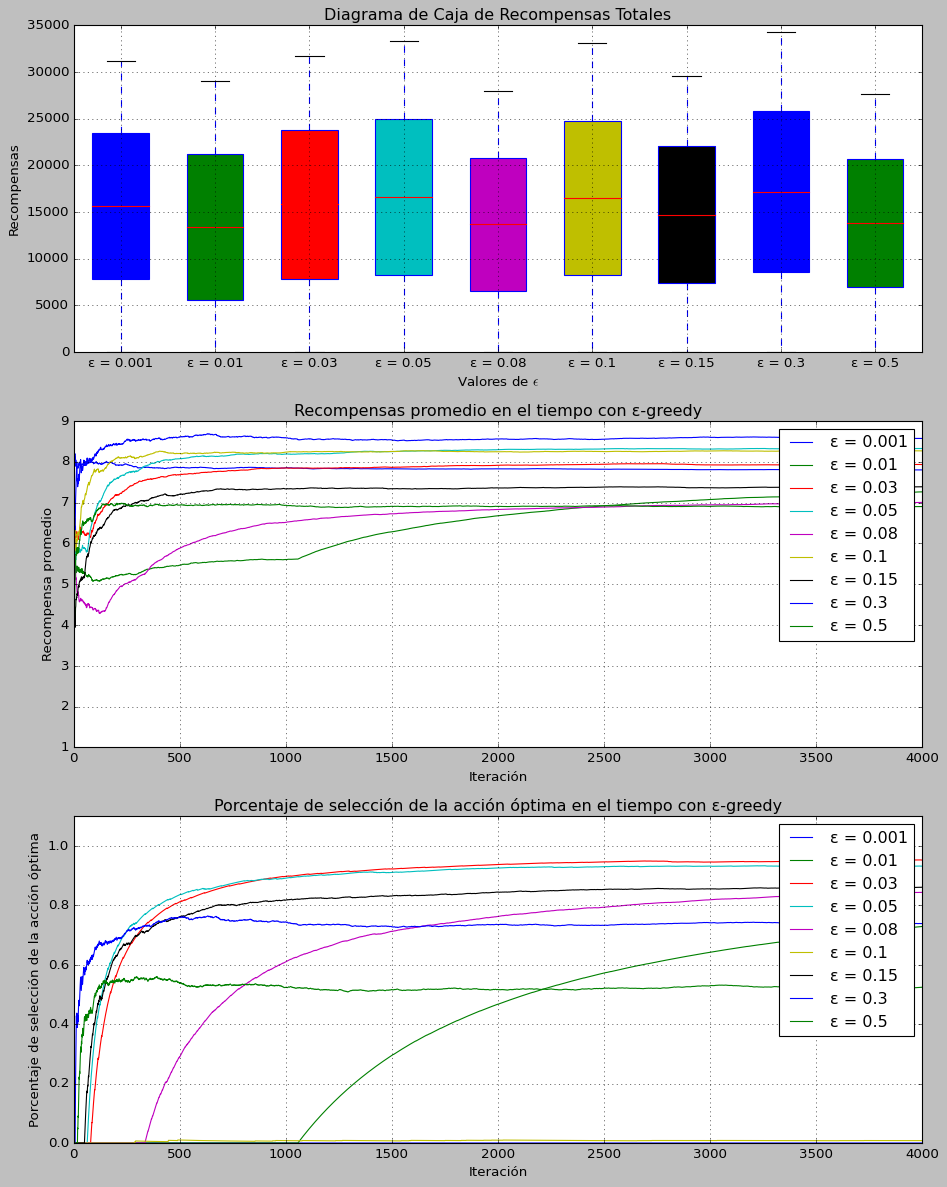

In [100]:
class BanditTestbed:
    # conditions
    np.random.seed(1)

    def __init__(self, num_bandits, mean, varianceInitBandits):
        self.bandits_mean_values = np.random.normal(mean, np.sqrt(varianceInitBandits), size=num_bandits)
        self.action_values = np.zeros(num_bandits)
        self.action_counts = np.zeros(num_bandits)
        self.total_rewards = 0
        self.q_estimated = np.zeros(num_bandits)
        self.optimal_action_count = 0
        self.rewards_history = []
        self.rewards_avg = []
        self.optimal_action_percentage_history = []
        self.bandits = num_bandits

    def pullArm(self, action, varianceActions):
        reward = np.random.normal(self.bandits_mean_values[action], varianceActions)
        self.q_estimated[action] = self.action_values[action]/(self.action_counts[action]+1e-5) #Cabe resaltar que el valor de 1e-5 se introduce para evitar que la división tienda a infinito cuando el número de acciones tomadas es 0.
        self.action_values[action] += reward
        self.action_counts[action] += 1
        self.total_rewards += reward
        self.rewards_history.append(reward)
        if action == np.argmax(self.bandits_mean_values):
            self.optimal_action_count += 1
        self.optimal_action_percentage_history.append(self.optimal_action_count / sum(self.action_counts))
        
    def greedy(self):
        action = np.argmax(self.action_values/(self.action_counts + 1e-5))
        return action

    def epsilon_greedy(self, epsilon, num_iterations, varianceActions):
        rewards = []
        rewards_avg = []
        for i in range(num_iterations):
            rand_num = np.random.rand()
            if rand_num < epsilon:
                action = np.random.choice(num_bandits)
            else:
                action = self.greedy() 
            self.pullArm(action, varianceActions)    
            rewards.append(self.total_rewards)
            rewards_avg.append(self.total_rewards / (i + 1))
        return rewards, self.optimal_action_percentage_history, rewards_avg


def run_experiment(num_bandits, num_iterations, epsilon_values, varianceActions, mean, varianceInitBandits):
    rewards_history = []
    rewards_avg = []
    optimal_action_percentage_history = []
    for epsilon in epsilon_values:
        testbed = BanditTestbed(num_bandits, mean, varianceInitBandits)
        rewards, optimal_action_percentage, rewards_av = testbed.epsilon_greedy(epsilon, num_iterations, varianceActions)
        rewards_history.append(rewards)
        rewards_avg.append(rewards_av)
        optimal_action_percentage_history.append(optimal_action_percentage)
    return rewards_history, optimal_action_percentage_history, rewards_avg


def plot_results(epsilon_values, rewards_history, optimal_action_percentage_history, rewards_avg):
    plt.figure(figsize=(12, 15))
    plt.subplot(3, 1, 1)
    for i, epsilon in enumerate(epsilon_values):
        plt.boxplot(rewards_history[i], positions=[i+1], widths=0.6, patch_artist=True, boxprops=dict(facecolor=f'C{i}'))
    plt.xlabel(r'Valores de $\epsilon$')
    plt.ylabel('Recompensas')
    plt.title('Diagrama de Caja de Recompensas Totales')
    plt.xticks(range(1, len(epsilon_values) + 1), [f'ε = {epsilon}' for epsilon in epsilon_values])
    plt.grid()
    plt.tight_layout()
    plt.subplot(3, 1, 2)
    for i, epsilon in enumerate(epsilon_values):
        plt.plot(rewards_avg[i], label=f'ε = {epsilon}')
    plt.xlabel('Iteración')
    plt.ylabel('Recompensa promedio')
    plt.title('Recompensas promedio en el tiempo con ε-greedy')
    plt.legend()
    plt.grid()
    plt.subplot(3, 1, 3)
    for i, epsilon in enumerate(epsilon_values):
        plt.plot(optimal_action_percentage_history[i], label=f'ε = {epsilon}')
    plt.xlabel('Iteración')
    plt.ylabel('Porcentaje de selección de la acción óptima')
    plt.title('Porcentaje de selección de la acción óptima en el tiempo con ε-greedy')
    plt.ylim(0, 1.1)
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

num_bandits = 12
mean = 5
varianceInitBandits = 3
varianceActions = 1
num_iterations = 4000
epsilon_values = [0.001, 0.01, 0.03, 0.05, 0.08, 0.1, 0.15, 0.3, 0.5]

rewards_history, optimal_action_percentage_history, reward_average = run_experiment(num_bandits, num_iterations, epsilon_values, varianceActions, mean, varianceInitBandits)
plot_results(epsilon_values, rewards_history, optimal_action_percentage_history, reward_average)

La primera gráfica muestra la suma de recompensas obtenidas para cada ϵ. La segunda gráfica muestra las recompensas promedio en el tiempo. Por último, la tercera gráfica muestra el porcentaje de selección de la acción óptima. Para poder saber si la acción escogida era o no la óptima, se utilizó la acción cuya media de la distribución fuera más alta. Cabe resaltar que esto es algo que en la vida real no conoceríamos a priori, pero se utiliza para analizar el comportamiento. Una manera de conocer cuál es la mejor acción es a partir del estimativo, con alguno de los métodos presentados anteriormente. Sin embargo, esas son precisamente estimaciones, y no tenemos total certeza de que efectivamente sea la acción óptima. Por tal motivo y con el propósito de entender el comportamiento de los multi-armed bandits, se utilizó la acción cuya media de la distribución fuera más alta.

### Punto 1.b) ϵ-greedy con tamaño de paso constante

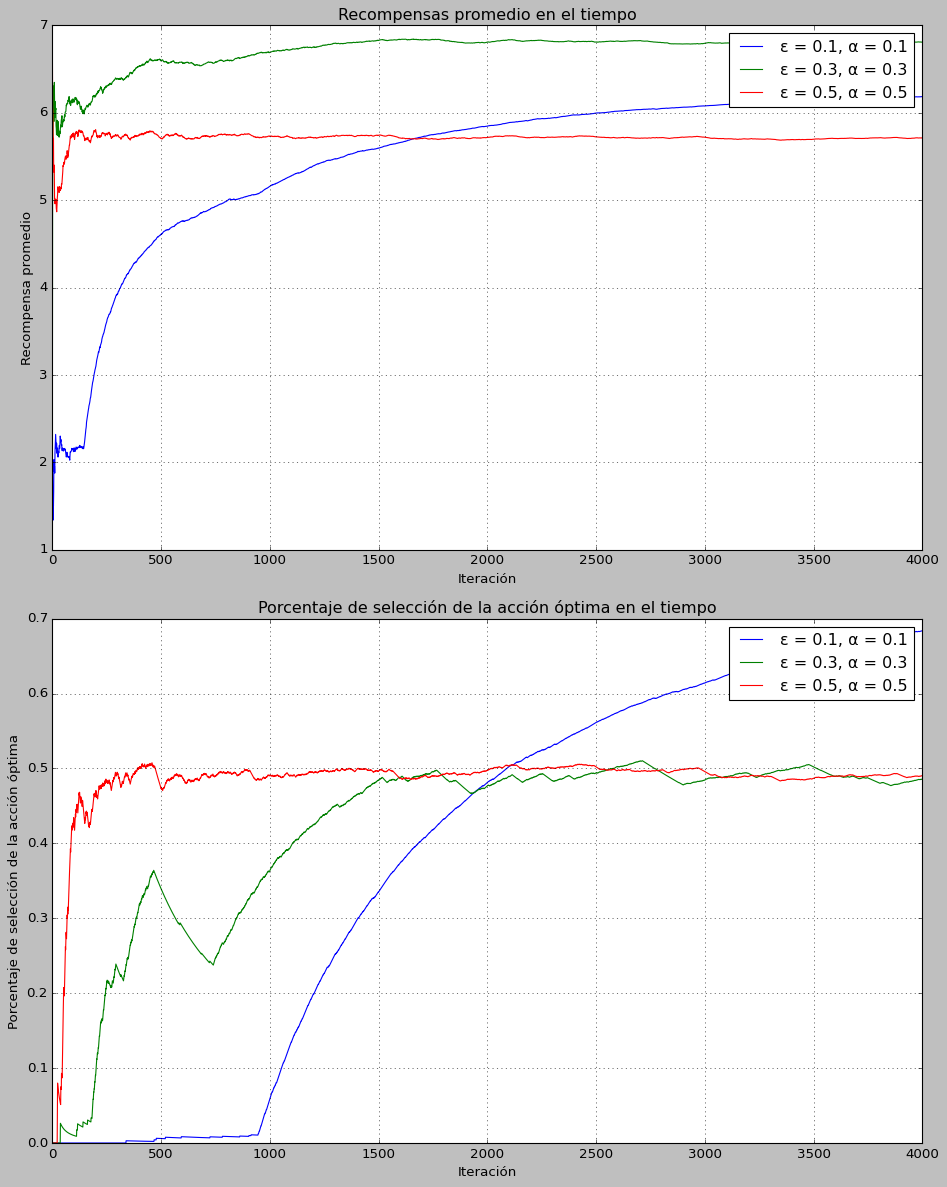

In [112]:
class BanditTestbed:
    def __init__(self, num_bandits, mean, varianceInitBandits, Q1):
        self.bandits_mean_values = np.random.normal(mean, np.sqrt(varianceInitBandits), size=num_bandits)
        self.action_values = np.zeros(num_bandits)
        self.action_counts = np.zeros(num_bandits)
        self.Q = np.zeros((num_iterations, num_bandits))
        self.q_estimated =  np.full(num_bandits, Q1)
        self.Q[0 , : ] = self.q_estimated
        self.total_rewards = 0
        self.num_bandits = num_bandits
        self.optimal_action_count = 0
        self.rewards_history = []
        self.rewards_avg = []
        self.optimal_action_percentage_history = []
        self.bandits = num_bandits
        self.rewards = np.zeros((num_iterations, num_bandits))

    def pullArm(self, action, varianceActions, alpha):
        reward = np.random.normal(self.bandits_mean_values[action], varianceActions)
        self.action_counts[action] += 1
        self.action_values[action] += reward
        self.total_rewards += reward
        IND = int(self.action_counts[action])
        self.rewards[IND - 1, action] = reward
        self.Q[IND, action] = self.Q[IND - 1, action] + alpha*(reward - self.Q[IND - 1, action])
        self.q_estimated[action] = self.Q[IND, action] 
        self.rewards_history.append(reward)
        if action == np.argmax(self.bandits_mean_values):
            self.optimal_action_count += 1
        self.optimal_action_percentage_history.append(self.optimal_action_count / sum(self.action_counts))

    def greedy(self):
            action = np.argmax(self.q_estimated)
            return action

    def epsilon_greedy(self, epsilon, num_iterations, varianceActions, alpha):
        rewards = []
        for i in range(num_iterations):
            rand_num = np.random.rand()
            if rand_num < epsilon:
                action = np.random.choice(self.num_bandits)
            else:
                action = self.greedy()
            self.pullArm(action, varianceActions, alpha)    
            rewards.append(self.total_rewards)
        rewards_avg = [r / (i + 1) for i, r in enumerate(rewards)]
        return rewards, self.optimal_action_percentage_history, rewards_avg
    
def run_experiment(num_bandits, num_iterations, epsilon_values, alpha_values, varianceActions, mean, varianceInitBandits, Q1):
    results = []
    for epsilon, alpha in zip(epsilon_values, alpha_values):
        testbed = BanditTestbed(num_bandits, mean, varianceInitBandits, Q1)
        rewards, optimal_action_percentage, rewards_av = testbed.epsilon_greedy(epsilon, num_iterations, varianceActions, alpha)
        results.append((epsilon, alpha, rewards_av, optimal_action_percentage))
    return results


def plot_results(results):
    plt.figure(figsize=(12, 15))
    # Plot for average rewards
    plt.subplot(2, 1, 1)
    for epsilon, alpha, rewards_avg, _ in results:
        plt.plot(rewards_avg, label=f'ε = {epsilon}, α = {alpha}')
    plt.xlabel('Iteración')
    plt.ylabel('Recompensa promedio')
    plt.title('Recompensas promedio en el tiempo')
    plt.legend()
    plt.grid()
    
    # Plot for optimal action percentage
    plt.subplot(2, 1, 2)
    for epsilon, alpha, _, optimal_action_percentage in results:
        plt.plot(optimal_action_percentage, label=f'ε = {epsilon}, α = {alpha}')
    plt.xlabel('Iteración')
    plt.ylabel('Porcentaje de selección de la acción óptima')
    plt.title('Porcentaje de selección de la acción óptima en el tiempo')
    plt.legend()
    plt.grid()
    
    plt.tight_layout()
    plt.show()


# Definir parámetros
num_bandits = 12
num_iterations = 4000
epsilon_values = [0.1, 0.3, 0.5]
alpha_values = [0.1, 0.3, 0.5]
varianceActions = 1
mean = 5
varianceInitBandits = 3
Q1 = 1

results = run_experiment(num_bandits, num_iterations, epsilon_values, alpha_values, varianceActions, mean, varianceInitBandits, Q1)
plot_results(results)

**2. Repita el problema anterior, pero ahora con cada acción con varianza de 4.**


En el caso en el que la varianza es 4 para todas las recompesas de las acciones, se analizó lo siguiente:

En el sistema, al tener una mayor varianza en el diagrama de cajas de recompesas, es apreciable la diferenciación entre las recompensas acumuladas, ya que para cada una de las distribuciones de probabilidad de las acciones, dado un valor de $\epsilon$, existe una probabilidad mayor de tener valores más alejados teniendo en cuenta que la distribución para todas las acciones se ha vuelto más grande para un dominio $\real$.

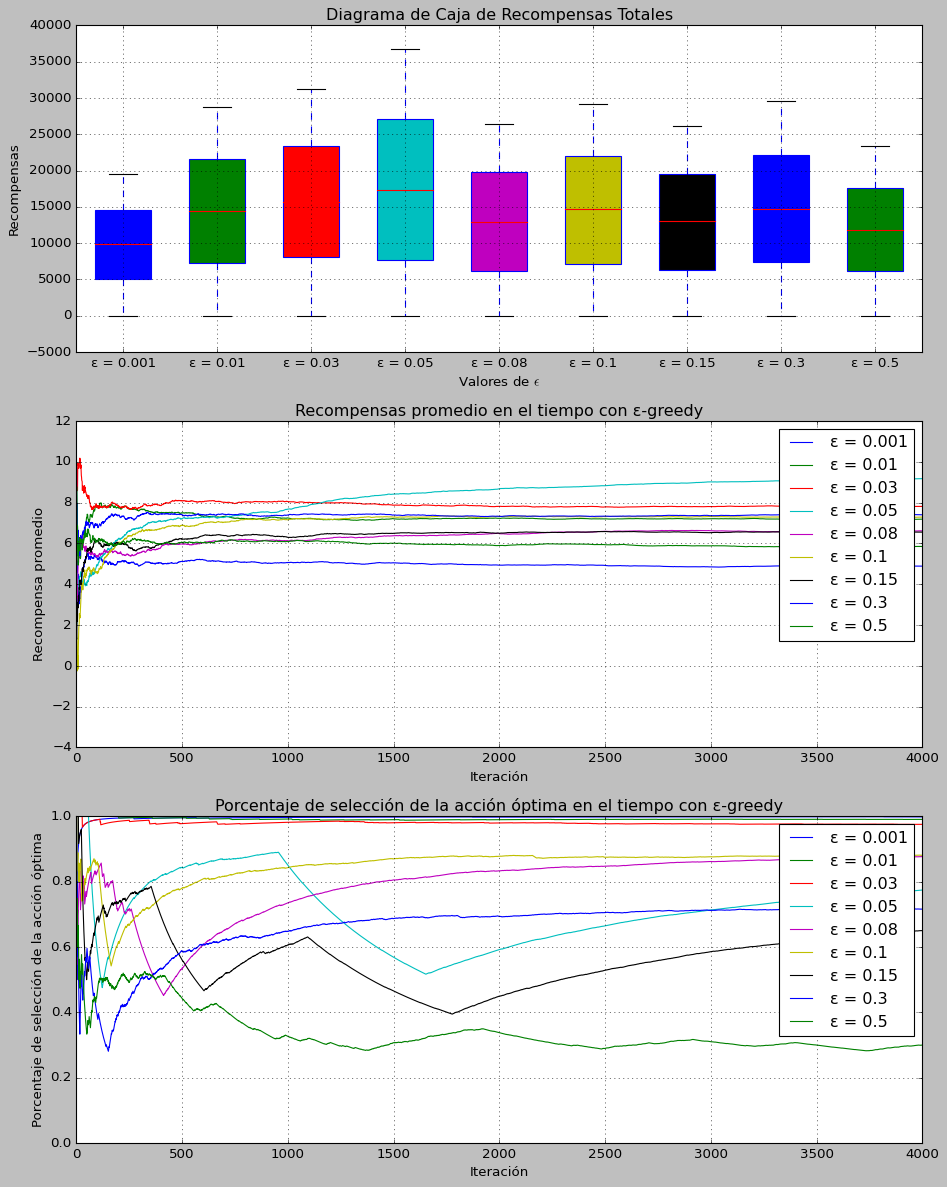

In [4]:
num_bandits = 12
mean = 5
varianceInitBandits = 3
varianceActions = 4
num_iterations = 4000
epsilon_values = [0.001, 0.01, 0.03, 0.05, 0.08, 0.1, 0.15, 0.3, 0.5]

rewards_history, optimal_action_percentage_history, reward_average = run_experiment(num_bandits, num_iterations, epsilon_values, varianceActions, mean, varianceInitBandits)
plot_results(epsilon_values, rewards_history, optimal_action_percentage_history, reward_average)

Como se puede notar, ahora 

### Punto No. 3 Mayor cantidad de Bandits

En este escenario, la existencia de un mayor número de acciones disponibles en cada estado episódico incrementa significativamente las oportunidades de exploración. Aunque la probabilidad de explorar (determinada por el valor de epsilon, $\epsilon$) se mantiene constante para cada caso, la diversidad ampliada de acciones asegura que, durante la fase de exploración, el algoritmo tenga una mayor probabilidad de seleccionar una acción diferente a la elegida previamente. Esto reduce la probabilidad de repetición de acciones, enriqueciendo así la experiencia. Cuando el algoritmo opta por la estrategia 'greedy', selecciona la mejor acción conocida basándose en las estimaciones actuales de valor. Dado un conjunto suficientemente grande y diverso de acciones, esta metodología garantiza que la política de decisión evolucione de manera más efectiva, beneficiándose de un balance óptimo entre exploración y explotación. La riqueza de opciones disponibles promueve una exploración más exhaustiva del espacio de acciones, lo que potencialmente conduce a una mejor identificación de políticas óptimas en entornos complejos.

In [94]:
num_bandits = 50
mean = 5
varianceInitBandits = 3
varianceActions = 1
num_iterations = 4000
epsilon_values = [0.001, 0.01, 0.03, 0.05, 0.08, 0.1, 0.15, 0.3, 0.5]
rewards_history, optimal_action_percentage_history, reward_average = run_experiment(num_bandits, num_iterations, epsilon_values, varianceActions, mean, varianceInitBandits)
plot_results(epsilon_values, rewards_history, optimal_action_percentage_history, reward_average)

TypeError: run_experiment() missing 1 required positional argument: 'varianceInitBandits'

### Punto No. 4 Caso no estacionario
Para el caso del punto 4, tenemos un caso no estacionario donde para la acción en este caso el bandit no existe una distribución fija donde se cumple que:
\begin{equation}
\mu = q_{*}(a_{k}) + cos(\frac{\pi}{120}(t-20))
\end{equation}
Para estos casos se tendra una distribución dependiente en el tiempo por lo que no importa para fines prácticos lo que ve muy alejado del momento actual, se puede notar que existe, una predominancia en los valores más cercanos. Para este caso se tomara un promedio pesado establecido como: 
\begin{equation}
Q_{n+1} = (1 - \alpha)^{n}Q_{1} + \sum_{i=1}^{n} \alpha (1-\alpha)^{n-i}R_{i}
\end{equation}
Para este caso en particular podemos ver que existe una dependencia para los valores de $Q_{1}$, donde por si mismo este puede ser fundamental para una inicialización optimista, ya que esta, tiende a fomentar la exploración inicial, encontrando valores deseados, en particular se cumple que:
\begin{equation}
Q_{1}(a) = v_{0}
\end{equation}
Donde $v_{0}$ para un promedio pesado se vuelve un valor cercano a 0, a continuación una demostración:

In [84]:
def pullArm(action, alpha, rewards, action_values, action_counts, varianceActions, v0, iteracion):
    reward = np.random.normal(5, varianceActions)  # Establecemos un valor constante para la recompensa
    action_values[action] += reward
    action_counts[action] += 1
    index = iteracion
    rewards[index - 1, action] = reward
    # Calculamos Q_step
    Q_step = 0
    for j in range(index):
        Q_step += alpha*((1 - alpha) ** (index - j - 1)) * rewards[j, action]

    # Actualizamos Q_sum sin considerar reward[0, action]
    Q_sum = ((1 - alpha)**(action_counts[action])) * v0 + Q_step
    print('En la iteración {} el valor de v0 en el aporte al promedio pesado es {}, siendo inicialmente {}'.format(index, ((1 - alpha) ** index) * v0, v0))
    return Q_sum

# Ejemplo de uso
num_bandits = 12
alpha = 0.3
varianceActions = 1
action_values = np.zeros(num_bandits)
action_counts = np.zeros(num_bandits)
rewards = np.random.normal(5, 1, size=(10, num_bandits))  # Hacemos el número de counts grande
v0 = 6

iteracion = 10

Q_sum = pullArm(0, alpha, rewards, action_values, action_counts, varianceActions, v0, iteracion)

En la iteración 10 el valor de v0 en el aporte al promedio pesado es 0.16948514939999987, siendo inicialmente 6


Variando los valores anteriormente mostrados es facil ver que para una inicialización optimista no afecta en el caso de distribuciónes no estables, si bien es cierto esto mejora en general el promedio puede llegar a afectar la inicialización, como en el caso de el siguiente experimento:

#### Experimento 4  
Para este experimento se tomo un valor fijo de $\alpha = 0.3$ y un valor de $Q_{1} = 0$, evaluando el caso realista para cada una, ahora bien, tomando en cuenta las recompensas promedio podriamos establecer que esta se optimiza con respecto a la asignación de la función Q, para todo modelo basado en la función estado-retorno, se plantea la maximización de la misma donde se cumple que:
\begin{equation}
a = arg_{i\in {1,...,k}} \max{Q_{t}(a_{i})}
\end{equation}
Donde en este caso se tomara este $Q_{t}$ como el estimativo basado en un promedio pesado.

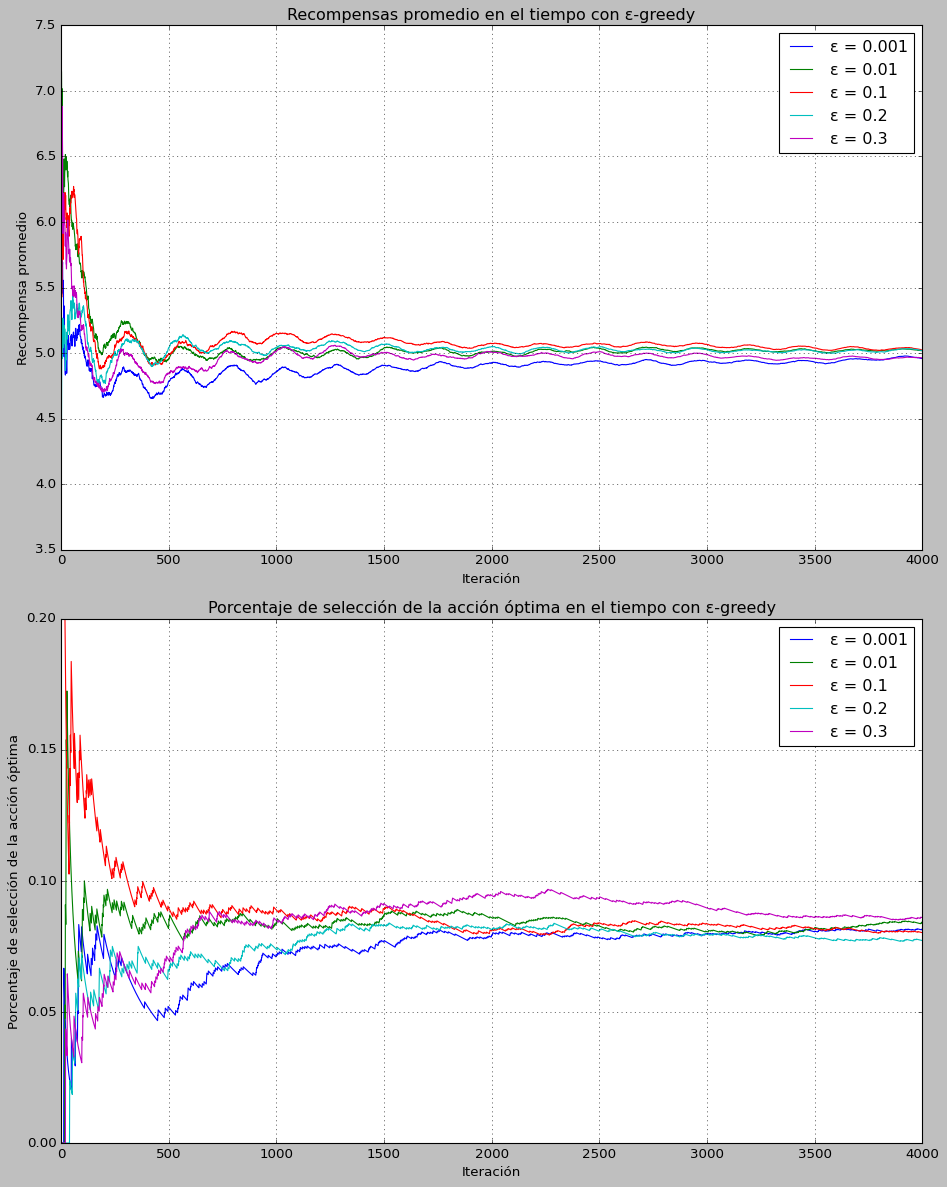

In [120]:
class BanditTestbed_change:
    np.random.seed(0)
    def __init__(self, num_bandits, mean, varianceInitBandits, alpha, num_iterations, Q1):
        self.action_values = np.zeros(num_bandits)
        self.action_counts = np.zeros(num_bandits)
        self.Q_sum = np.zeros(num_bandits)
        self.total_rewards = 0
        self.mean = mean
        self.alpha = alpha
        self.Q1 = Q1
        self.optimal_action_count = 0
        self.rewards_history = []
        self.optimal_action_percentage_history = []
        self.num_bandits = num_bandits
        self.varianceInitBandits = varianceInitBandits
        self.rewards = np.zeros((num_iterations, num_bandits))
        # Inicialización de bandits_mean_values
        self.bandits_mean_values = np.random.normal(mean, np.sqrt(varianceInitBandits), size=num_bandits)

    def pullArm(self, action, varianceActions):
        reward = np.random.normal(self.bandits_mean_values[action], varianceActions)
        self.action_values[action] += reward
        self.action_counts[action] += 1
        index = int(self.action_counts[action])
        self.rewards[index - 1, action] = reward
        Q_step = 0
        for j in range(index):
            Q_step += self.alpha*((1 - self.alpha) ** (index - j - 1)) * self.rewards[j, action]
        # Corrección en la actualización de Q_sum
        self.Q_sum[action] = ((1 - self.alpha)**(self.action_counts[action])) * self.Q1 + Q_step
        self.total_rewards += reward
        self.rewards_history.append(reward)
        if action == np.argmax(self.bandits_mean_values):
            self.optimal_action_count += 1
        self.optimal_action_percentage_history.append(self.optimal_action_count / sum(self.action_counts))
        
    def greedy(self):
        action = np.argmax(self.Q_sum)
        return action

    def epsilon_greedy(self, epsilon, num_iterations, varianceActions):
        rewards = []
        for i in range(num_iterations):
            self.bandits_mean_values = np.random.normal(self.mean , np.sqrt(self.varianceInitBandits), size=self.num_bandits) + np.cos((np.pi / 120) * (i - 20))
            rand_num = np.random.rand()
            if rand_num < epsilon:
                action = np.random.choice(self.num_bandits)
            else:
                action = self.greedy()
            self.pullArm(action, varianceActions)    
            rewards.append(self.total_rewards)
        rewards_avg = [r / (i + 1) for i, r in enumerate(rewards)]
        return rewards, self.optimal_action_percentage_history, rewards_avg


def run_experiment_2(num_bandits, num_iterations, epsilon_values, varianceActions, mean, varianceInitBandits, alpha, Q1):
    rewards_history = []
    rewards_avg = []
    optimal_action_percentage_history = []
    for epsilon in epsilon_values:
        testbed = BanditTestbed_change(num_bandits, mean, varianceInitBandits, alpha, num_iterations, Q1)
        rewards, optimal_action_percentage, rewards_av = testbed.epsilon_greedy(epsilon, num_iterations, varianceActions)
        rewards_history.append(rewards)
        rewards_avg.append(rewards_av)
        optimal_action_percentage_history.append(optimal_action_percentage)
    return rewards_history, optimal_action_percentage_history, rewards_avg



def plot_results2(epsilon_values, rewards_history, optimal_action_percentage_history, rewards_avg):
    plt.figure(figsize=(12, 15))
    plt.subplot(2, 1, 1)
    for i, epsilon in enumerate(epsilon_values):
        plt.plot(rewards_avg[i], label=f'ε = {epsilon}')
    plt.xlabel('Iteración')
    plt.ylabel('Recompensa promedio')
    plt.title('Recompensas promedio en el tiempo con ε-greedy')
    plt.legend()
    plt.grid()
    plt.subplot(2, 1, 2)
    for i, epsilon in enumerate(epsilon_values):
        plt.plot(optimal_action_percentage_history[i], label=f'ε = {epsilon}')
    plt.xlabel('Iteración')
    plt.ylabel('Porcentaje de selección de la acción óptima')
    plt.title('Porcentaje de selección de la acción óptima en el tiempo con ε-greedy')
    plt.legend()
    plt.grid()
    plt.ylim([0, 0.2])
    plt.tight_layout()
    plt.show()

alpha = 0.3
num_bandits = 12
mean = 5
varianceInitBandits = 3
varianceActions = 1
num_iterations = 4000
epsilon_values = [0.001, 0.01, 0.1, 0.2, 0.3]
Q1 = 0

rewards_history, optimal_action_percentage_history, reward_average  = run_experiment_2(num_bandits, num_iterations, epsilon_values, varianceActions, mean, varianceInitBandits, alpha, Q1)
plot_results2(epsilon_values, rewards_history, optimal_action_percentage_history, reward_average)

Para este caso podemos ver como para todas las recompensas promedio se tiende a la media original de la distribución de la cual provienen los $\mu$ de las distribuciones de acciones para este caso como se crean estas distribuciónes para cada iteración t, tiene sentido que converjan a la media original, tomando como referencia de que todas estan centradas en el mismo valor, visto de forma expresada tendremos que:
\begin{equation}
q_{*}(a_i)_{t} = E[R_{t}|A_{t}=a_{1}]
\end{equation}
Dadas unas distribuciones diferentes para cada t
\begin{equation}
\sum_{i=1}^{N}q_{*}(a_{*})_{i} = \mu
\end{equation}
Ya que todas estas distribuciones actuaran como variables independientes tal que se cumple
\begin{equation}
q_{1} + q_{2} + q_{3} + ... + q_{n} = \mu * n 
\end{equation}
**Llegando asi a la convergencia asintótica con respecto a la media.** Para el caso de los comportamientos según el $\epsilon$ para un valor de 0.3, podemos notar que para las primeras 500 es peor que los valores de epsilon directamente cercanos a cero, por tal motivo, podemos afirmar que se encuentra en la etapa de exploración que establece que con el $30\%$ de las posibilidades se encuentra explorando acciones que no pertenecen a la acción greedy, sin embargo, para valores mayores a esta iteración esta se comporta mejor que todas, aunque este valor es pequeño, ya que, la distribución de medias no es completamente estocastico esto en gran medida teniendo en cuenta su parte periodica, ya que toma los puntos mas cercanos 0.3 es valor de descuento bajo en terminos que con este seguira teniendo en cuenta las recompensas más lejanas por lo que si este no es lo suficientemente grande, se comportara como una derivada entre dos puntos alejados, por lo que optara por una acción que se ve con recompensa optima, sin embargo, debido a la distribución variable esta por cambiar a un valor menor.

---

Ahora bien para realizar una estrategia diferente haremos uso de la inicialización optimista, variando los valores de $\alpha$ y $\epsilon$, para tratar de encontrar el pareto de desempeño para el modelo de función de densidad no estable, en particular, haremos uso de un $Q_{1}$ igual a 10 variando los valores, para encontrar en máximo porcentaje óptimo.

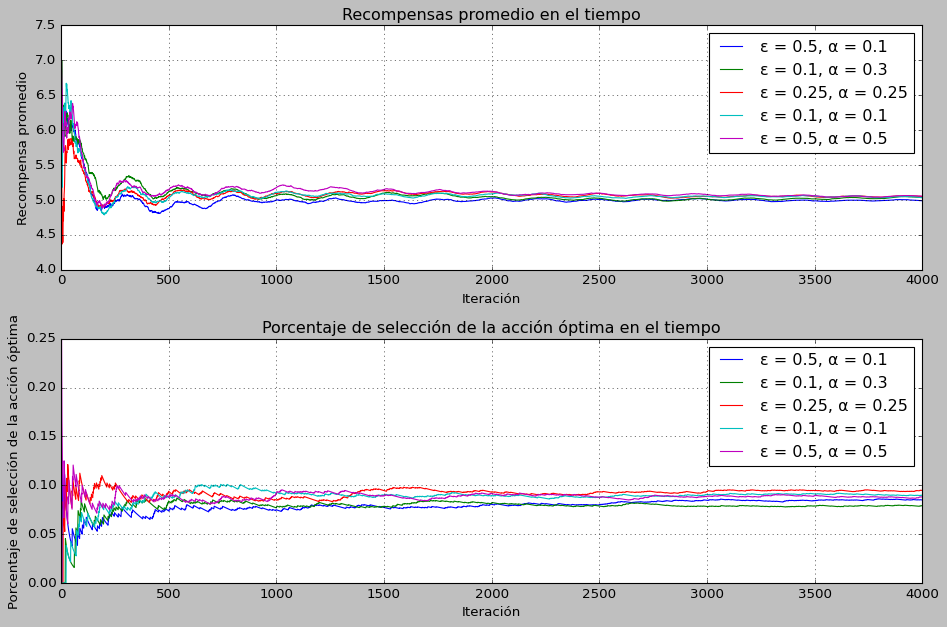

In [133]:
class BanditTestbed_change:
    np.random.seed(0)
    def __init__(self, num_bandits, mean, varianceInitBandits, num_iterations, Q1):
        self.action_values = np.zeros(num_bandits)
        self.action_counts = np.zeros(num_bandits)
        self.Q_sum = np.zeros(num_bandits)
        self.total_rewards = 0
        self.mean = mean
        self.Q1 = Q1
        self.optimal_action_count = 0
        self.rewards_history = []
        self.optimal_action_percentage_history = []
        self.num_bandits = num_bandits
        self.varianceInitBandits = varianceInitBandits
        self.rewards = np.zeros((num_iterations, num_bandits))
        self.bandits_mean_values = np.random.normal(mean, np.sqrt(varianceInitBandits), size=num_bandits)

    def pullArm(self, action, varianceActions, alpha):
        reward = np.random.normal(self.bandits_mean_values[action], varianceActions)
        self.action_values[action] += reward
        self.action_counts[action] += 1
        index = int(self.action_counts[action])
        self.rewards[index - 1, action] = reward
        Q_step = 0
        
        # SUMATORIA SOBRE RECOMPENSAS
        for j in range(index):
            Q_step += alpha * ((1 - alpha) ** (index - j - 1)) * self.rewards[j, action]

        # EXPRESION Q
        self.Q_sum[action] = ((1 - alpha) ** (self.action_counts[action])) * self.Q1 + Q_step
        self.total_rewards += reward
        self.rewards_history.append(reward)
        if action == np.argmax(self.bandits_mean_values):
            self.optimal_action_count += 1
        self.optimal_action_percentage_history.append(self.optimal_action_count / sum(self.action_counts))
        
    def greedy(self):
        action = np.argmax(self.Q_sum)
        return action

    def epsilon_greedy(self, epsilon, num_iterations, varianceActions, alpha):
        rewards = []
        for i in range(num_iterations):
            self.bandits_mean_values = np.random.normal(self.mean, np.sqrt(self.varianceInitBandits), size=self.num_bandits) + np.cos((np.pi / 120) * (i - 20))
            rand_num = np.random.rand()
            if rand_num < epsilon:
                action = np.random.choice(self.num_bandits)
            else:
                action = self.greedy()
            self.pullArm(action, varianceActions, alpha)    
            rewards.append(self.total_rewards)
        rewards_avg = [r / (i + 1) for i, r in enumerate(rewards)]
        return rewards, self.optimal_action_percentage_history, rewards_avg


def run_experiment_2(num_bandits, num_iterations, epsilon_values, alphas, varianceActions, mean, varianceInitBandits, Q1):
    results = []
    for epsilon, alpha in zip(epsilon_values, alphas):
        testbed = BanditTestbed_change(num_bandits, mean, varianceInitBandits, num_iterations, Q1)
        rewards, optimal_action_percentage, rewards_avg = testbed.epsilon_greedy(epsilon, num_iterations, varianceActions, alpha)
        results.append((epsilon, alpha, rewards_avg, optimal_action_percentage))
    return results


def plot_results2(results):
    plt.figure(figsize=(12, 8))
    
    # Plot for average rewards
    plt.subplot(2, 1, 1)
    for epsilon, alpha, rewards_avg, _ in results:
        plt.plot(rewards_avg, label=f'ε = {epsilon}, α = {alpha}')
    plt.xlabel('Iteración')
    plt.ylabel('Recompensa promedio')
    plt.title('Recompensas promedio en el tiempo')
    plt.legend()
    plt.grid()
    
    # Plot for optimal action percentage
    plt.subplot(2, 1, 2)
    for epsilon, alpha, _, optimal_action_percentage in results:
        plt.plot(optimal_action_percentage, label=f'ε = {epsilon}, α = {alpha}')
    plt.xlabel('Iteración')
    plt.ylabel('Porcentaje de selección de la acción óptima')
    plt.title('Porcentaje de selección de la acción óptima en el tiempo')
    plt.legend()
    plt.grid()
    
    plt.tight_layout()
    plt.show()


# Parámetros del experimento
num_bandits = 12
mean = 5
varianceInitBandits = 3
varianceActions = 1
num_iterations = 4000
epsilon_values = [0.5, 0.1, 0.25, 0.1, 0.5]  # Lista de valores de epsilon
alphas = [0.1, 0.3, 0.25, 0.1, 0.5]  # Lista de valores de alpha correspondientes
Q1 = 20


results = run_experiment_2(num_bandits, num_iterations, epsilon_values, alphas, varianceActions, mean, varianceInitBandits, Q1)
plot_results2(results)

Para este caso nos enocntramos con que tener una tasa de exploración moderada cercana a un $\epsilon=0.25$ y un tamaño de paso de $\alpha=0.25$, con un crecimiento estable, en otros casos tiene sobredimensionamiento de los valores, explorando demasiado sobre las acciones, no corvengiendo a una respuesta mayor, sin bien pasa lo contrario para valores de paso algo y exploración baja ya que es dominante ante el tamaño de paso se comportara como greedy.

- Prueba

## Conclusiones

- Al utilizar el método greedy se selecciona la mejor acción según el estimativo de la distribución de probabilidad. Sin embargo, debido a que solo se tiene un estimativo, no hay completa certeza de que la acción tomada sea la óptima. Este método se enfoca puramente en explotación y no incentiva la exploración, por lo que la acción óptima puede no ser encontrada nunca. Es así como el método ϵ-greedy propone una manera de explorar más, con el fin de encontrar acciones óptimas.

- A partir de los resultados, podemos darnos cuenta de que un valor de ϵ muy grande no es siempre muy bueno, pues se enfoca en explorar demasiado y no en explotar. Del mismo modo, un ϵ muy pequeño se enfoca en explotar demasiado y no en explorar otras alternativas.

- Podemos notar que si las acciones tienen varianza muy grande, el mejor ϵ tiende a ser mayor, mientras que si la varianza es más pequeña, el mejor ϵ tiende a ser menor.
